## Generative Latent Replay

Experimental code to test generative latent replay on benchmark continual learning problems.

i.e. normalising bottleneck representations and sampling from fitted GMM on latent space.

In [1]:
# ML imports
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torchvision import transforms as T
from avalanche.logging import (
    InteractiveLogger,
    TextLogger,
    TensorboardLogger,
    WandBLogger,
    CSVLogger,
)
from avalanche.training import Naive, Replay, plugins
from avalanche.training.plugins import EvaluationPlugin
from avalanche.benchmarks.classic import RotatedMNIST, PermutedMNIST
from avalanche.evaluation.metrics import (
    forgetting_metrics,
    accuracy_metrics,
    loss_metrics,
    timing_metrics,
    cpu_usage_metrics,
    confusion_matrix_metrics,
    disk_usage_metrics,
)

# Local imports
from src import utils, plotting, models
from src.strategies import LatentReplay, GenerativeLatentReplay


Setup

In [2]:
# Reproducibility
SEED = 731
utils.set_seed(SEED)

loggers = []
loggers.append(TextLogger(open('log.txt', 'a')))
loggers.append(CSVLogger())

Problem definition

In [3]:
# Dataset specific attributes
n_experiences = 5
transform = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])

experiences = PermutedMNIST(
        n_experiences=n_experiences,
        train_transform=transform,
        eval_transform=transform,
        seed=SEED,
        # rotations_list=[0, 60, 300],
    )

eval_plugin = EvaluationPlugin(
    accuracy_metrics(epoch=True, experience=True, stream=True),
    loss_metrics(epoch=True, experience=True, stream=True),
    #timing_metrics(epoch=True, epoch_running=True),
    #cpu_usage_metrics(experience=True),
    #forgetting_metrics(experience=True, stream=True),
    #confusion_matrix_metrics(num_classes=experiences.n_classes, save_image=True,
    #                         stream=True),
    #disk_usage_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loggers=loggers
)

Hyperparameters

In [4]:
# Replays
replay_buffer_size = 6000

# Frozen backbone
freeze_depth = 1
latent_layer_number = freeze_depth * 3

# Generic hyperparams
lr = 0.1  # 0.001
l2 = 0.0005
momentum = 0.9

eval_rate = 1

strategy_kwargs = {
    "train_epochs": 40,
    "train_mb_size": 128,
    "eval_mb_size": 512,
    "device": utils.get_device(),
    "plugins": [
        plugins.EarlyStoppingPlugin(
            patience=eval_rate, val_stream_name="train_stream/Task000", margin=0.01, #metric
        )
    ],
    "eval_every": eval_rate,
    "evaluator": eval_plugin,
}


Building base model

In [5]:
# Model specification
model = "mlp"

model_kwargs = {
    "drop_rate": 0,
    "num_classes": 10,
    "hidden_size": 100,
    "hidden_layers": 2,
}

In [6]:
# Model
n_models = 6

if model == "mlp":
    networks = [models.SimpleMLP(**model_kwargs) for i in range(n_models)]
    transform = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])

elif model == "cnn":
    networks = [models.SimpleCNN(**model_kwargs) for i in range(n_models)]
    transform = T.Compose([T.ToTensor()])

c:\Users\jacob\miniconda3\envs\env-glr\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Building Continual Learning methods for comparison

In [7]:
# Baseline
naive_strategy = Naive(
    model=networks[0],
    optimizer=SGD(networks[0].parameters(), lr=lr, momentum=momentum, weight_decay=l2),
    **strategy_kwargs,
)

# Benchmark - raw and latent replay
replay_strategy = Replay(
    model=networks[1],
    criterion=CrossEntropyLoss(),
    optimizer=SGD(networks[1].parameters(), lr=lr, momentum=momentum, weight_decay=l2),
    **strategy_kwargs,
)

# Sanity check - should perform similar to "Replay"
replay_thawed_strategy = LatentReplay(
   model=networks[2],
   latent_layer_num=0,
   subsample_replays=True,
   rm_sz=replay_buffer_size,
   **strategy_kwargs,
)

lat_replay_strategy = LatentReplay(
    model=networks[3],
    rm_sz=replay_buffer_size,
    latent_layer_num=latent_layer_number,
    subsample_replays=True,
    **strategy_kwargs,
)

gen_replay_strategy = GenerativeLatentReplay(
    model=networks[4],
    rm_sz=replay_buffer_size,
    latent_layer_num=0,
    **strategy_kwargs,
)

# Continual learning strategy
gen_lat_replay_strategy = GenerativeLatentReplay(
    model=networks[5],
    rm_sz=replay_buffer_size,
    latent_layer_num=latent_layer_number,
    **strategy_kwargs,
)

# print(gen_lat_replay_strategy.model)

In [8]:
strategies = {
    "Generative Latent Replay": {"model": gen_lat_replay_strategy, "results": []},
    #"Latent Replay": {"model": lat_replay_strategy, "results": []},
    #"Replay": {"model": replay_strategy, "results": []},
    #"Naive": {"model": naive_strategy, "results": []},
    #"Replay (re-imp)": {"model": replay_thawed_strategy, "results": []},
    #"Generative Replay": {"model": gen_replay_strategy, "results": []},
}

Training loop

In [9]:
for strat in strategies.values():
    train_stream = experiences.train_stream
    test_stream = experiences.test_stream

    for train_exp in train_stream:
        strat["model"].train(train_exp)
        strat["results"].append(strat["model"].eval(train_stream))

c:\Users\jacob\miniconda3\envs\env-glr\lib\site-packages\avalanche\training\plugins\early_stopping.py:112: UserWarning: Metric Top1_Acc_Stream used by the EarlyStopping plugin is not computed yet. EarlyStopping will not be triggered.
  warnings.warn(


Training generator 0...


c:\Users\jacob\miniconda3\envs\env-glr\lib\site-packages\sklearn\mixture\_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Generator trained.


c:\Users\jacob\miniconda3\envs\env-glr\lib\site-packages\avalanche\training\plugins\early_stopping.py:112: UserWarning: Metric Top1_Acc_Stream used by the EarlyStopping plugin is not computed yet. EarlyStopping will not be triggered.
  warnings.warn(


Training generator 1...
Generator trained.


c:\Users\jacob\miniconda3\envs\env-glr\lib\site-packages\avalanche\training\plugins\early_stopping.py:112: UserWarning: Metric Top1_Acc_Stream used by the EarlyStopping plugin is not computed yet. EarlyStopping will not be triggered.
  warnings.warn(


Training generator 2...
Generator trained.


c:\Users\jacob\miniconda3\envs\env-glr\lib\site-packages\avalanche\training\plugins\early_stopping.py:112: UserWarning: Metric Top1_Acc_Stream used by the EarlyStopping plugin is not computed yet. EarlyStopping will not be triggered.
  warnings.warn(


Training generator 3...
Generator trained.


c:\Users\jacob\miniconda3\envs\env-glr\lib\site-packages\avalanche\training\plugins\early_stopping.py:112: UserWarning: Metric Top1_Acc_Stream used by the EarlyStopping plugin is not computed yet. EarlyStopping will not be triggered.
  warnings.warn(


Training generator 4...
Generator trained.


Plotting

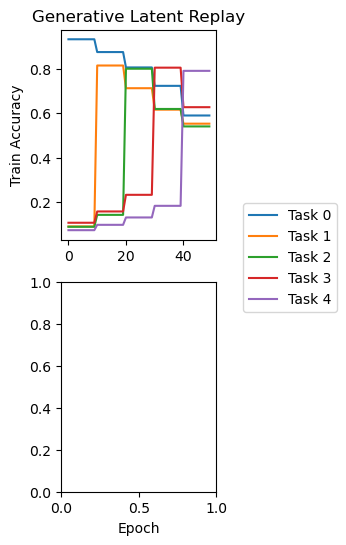

In [10]:
import importlib
importlib.reload(plotting)

results = [s["results"] for s in strategies.values()]
plotting.plot_multiple_results(results, strategies.keys(), n_experiences)

In [11]:
utils.results_to_df(strategies.keys(), results)

,Final Avg Acc
Generative Latent Replay,0.619930


In [12]:
print(results)

[[{'Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp000': 0.93135, 'Loss_Exp/eval_phase/train_stream/Task000/Exp000': 0.23936508865356446, 'Top1_Acc_Stream/eval_phase/train_stream/Task000': 0.25961666666666666, 'Loss_Stream/eval_phase/train_stream/Task000': 2.7797362100219725, 'Top1_Acc_Epoch/train_phase/train_stream/Task000': 0.9300333333333334, 'Loss_Epoch/train_phase/train_stream/Task000': 0.24414991318384807, 'Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp001': 0.09208333333333334, 'Loss_Exp/eval_phase/train_stream/Task000/Exp001': 3.133801282628377, 'Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp002': 0.0906, 'Loss_Exp/eval_phase/train_stream/Task000/Exp002': 3.610970734024048, 'Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp003': 0.10866666666666666, 'Loss_Exp/eval_phase/train_stream/Task000/Exp003': 3.232883576583862, 'Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp004': 0.07538333333333333, 'Loss_Exp/eval_phase/train_stream/Task000/Exp004': 3.6816603682200113}, {'Top1_Acc